In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
from collections import defaultdict, Counter
from pprint import pprint
import matplotlib.pyplot as plt

In [65]:
'''
TO DO LIST:
- convertir diccionario en dataframe del modulo fit
- añadir variable con el día de hoy usando datetime
'''

'\nTO DO LIST:\n- convertir diccionario en dataframe del modulo fit\n- añadir variable con el día de hoy usando datetime\n'

In [66]:
ticker = 'BTC-USD'
data = yf.download(ticker, start = '2000-01-01', end = '2023-09-13')

[*********************100%***********************]  1 of 1 completed


In [67]:
class MarkovModel:
    def __init__(self, N = 1):
        
        self.N = N + 1
        self.transitions = defaultdict(Counter)
        
    def fit(self, sequence):
        
        for i in range(len(sequence) - self.N):
            prefix = tuple(sequence[i : i + self.N -1])
            next_state = sequence[i + self.N - 1]
            self.transitions[prefix][next_state] += 1
            
        for prefix, counts in self.transitions.items():
            total = sum(counts.values())
            self.transitions[prefix] = {state: count/total *100 for state, count in counts.items()}
            
    def predict(self, current_state):
        
        if tuple(current_state[-self.N + 1: ]) not in self.transitions:
            return None
        next_states = self.transitions[tuple(current_state[-self.N + 1 : ])]
        return max(next_states, key = next_states.get)
    
    def generate(self, current_state):
        if tuple(current_state[-self.N + 1: ]) not in self.transitions:
            return None
        next_states = self.transitions[tuple(current_state[-self.N + 1 : ])]
        return random.choices(list(next_states.keys()), weights = list(next_states.values()))[0]

In [68]:
'''
- If N = 2
    1: retornos negativos, 2: retornos positivos
- If N = 3 
    1: retornos negativos, 2: retornos cercanos a 0, 3: retornos positivos 'altos'
- If N = 4 
    1: retornos negativos, 2: retornos negativos cercanos a 0, 3: retornos positivos cercanos a 0, 4: retornos positivos 'altos'
'''

N = 2 # número de estados posibles
data['returns'] = data['Adj Close'].pct_change()
data.dropna(inplace=True)
quantiles = np.percentile(data.returns, np.linspace(0, 100, N + 1)[1 : -1])
data['grouped_returns'] = data.returns.apply(lambda x: sum(x > quantiles) + 1) 
data

,Open,High,Low,Close,Adj Close,Volume,returns,grouped_returns
Date,,,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,1
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,1
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,2
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,1
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600,0.008352,2
...,...,...,...,...,...,...,...,...
2023-09-09,25905.425781,25921.976562,25810.494141,25895.677734,25895.677734,5481314132,-0.000385,1
2023-09-10,25895.210938,25978.130859,25640.261719,25832.226562,25832.226562,7899553047,-0.002450,1
2023-09-11,25831.714844,25883.947266,24930.296875,25162.654297,25162.654297,14600006467,-0.025920,1


In [69]:
lookback = 3
sequences = data.grouped_returns.to_list()
model = MarkovModel(N = lookback)
model.fit(sequences)
pprint(model.transitions)

defaultdict(<class 'collections.Counter'>,
            {(1, 1, 1): {1: 45.84450402144772, 2: 54.15549597855228},
             (1, 1, 2): {1: 52.70935960591133, 2: 47.29064039408867},
             (1, 2, 1): {1: 49.77777777777778, 2: 50.22222222222222},
             (1, 2, 2): {1: 54.01459854014598, 2: 45.98540145985402},
             (2, 1, 1): {1: 49.75369458128079, 2: 50.24630541871922},
             (2, 1, 2): {1: 51.868131868131876, 2: 48.13186813186813},
             (2, 2, 1): {1: 44.28223844282238, 2: 55.71776155717762},
             (2, 2, 2): {1: 51.49863760217984, 2: 48.50136239782017}})


In [70]:
predicted_state = model.predict(sequences[-lookback : ])
print(f'Current state: {sequences[-lookback : ]}')
print(f'Predicted state: {predicted_state}')

Current state: [1, 2, 2]
Predicted state: 1


In [71]:
generated_sate = model.generate(sequences[-lookback : ])
print(f'Current state: {sequences[-lookback : ]}')
print(f'Predicted next state: {generated_sate}')

Current state: [1, 2, 2]
Predicted next state: 2


In [72]:
clusters = set(sequences)
cluster_info = {}
for cluster in clusters:
    data_cluster = data[data['grouped_returns'] == cluster]
    mean = data_cluster['returns'].mean()
    stdev = data_cluster['returns'].std()
    cluster_info[cluster] = {}
    cluster_info[cluster]['mean'] = mean
    cluster_info[cluster]['stdev'] = stdev
pprint(cluster_info)     

{1: {'mean': -0.022559412727356353, 'stdev': 0.028259981802299963},
 2: {'mean': 0.026452852335453157, 'stdev': 0.028208094857575017}}


## Montecarlo

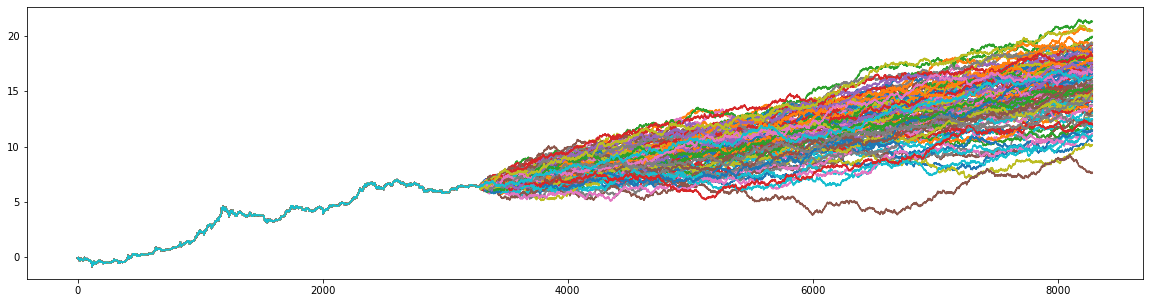

In [73]:
fig, ax = plt.subplots(figsize=[20,5])

mc_iter = 100

for i in range(mc_iter):
    future_steps = 5000
    sequences_forecast = sequences.copy()
    returns_forecast = []
    for j in range(future_steps):
        generated_sate = model.generate(sequences_forecast[-lookback : ])
        returns_forecast.append(cluster_info[generated_sate]['mean'] + cluster_info[generated_sate]['stdev'] * np.random.randn())
        sequences_forecast.append(generated_sate)
        
    y = data['returns'].tolist()[-future_steps : ]
    y.extend(returns_forecast)
    ax.plot(np.cumsum(y))
plt.show()